# Toy UKF + Causal Window Transformer NoiseNet (Full Cholesky Qx/R + pₖ→Qθ Gating)

This notebook implements a **minimal end-to-end toy** for your setup:

- **2-DOF** dynamics with state \(x=[q_1,q_2,v_1,v_2]\) (nx=4) and measurement \(y=[q_1,q_2]\) (ny=2)  
- **Augmented state** \(z=[x;\theta]\) with a **single parameter** \(\theta\) scaling stiffness  
- Sequence length **T=2000**, random change-point \(k^*\), and **+30% step jump** in \(\theta\)  
- A **causal Transformer** predicts **full SPD** \(Q_{x,k}\) and \(R_k\) via **Cholesky factors**, plus a change logit \(p_k\)  
- \(p_k\) gates \(Q_{\theta,k}\) inside the UKF predict covariance:
  \[
  Q_{\theta,k}=(1-\sigma(p_k))Q_{\theta}^{\text{base}}+\sigma(p_k)Q_{\theta}^{\text{jump}}
  \]
- Training uses **sliding windows** with **burn-in**, **state supervision**, and **BCE supervision** for change detection.

> Tip: Start with the default small training settings to sanity-check. Then increase epochs/steps to improve adaptation speed.


**Training note:** During training we **do not supervise θ** (no θ loss). We only use state GT (and likelihood terms) for learning. In synthetic experiments, θ GT is used **only for evaluation / reporting**.


In [1]:

# --- Setup ---
from __future__ import annotations
import math, random
from dataclasses import dataclass
from typing import Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import os


print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())


torch: 2.10.0+cu128
cuda available: True


In [2]:

# --- Config ---
@dataclass
class CFG:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    dtype: torch.dtype = torch.float32

    # problem dims
    nx: int = 4
    ny: int = 2
    nt: int = 1
    nz: int = 5

    # simulation
    dt: float = 0.02
    T: int = 2000
    jump_ratio: float = 0.30
    kstar_lo: float = 0.3
    kstar_hi: float = 0.7

    # UKF params
    alpha: float = 1.0
    beta: float = 2.0
    kappa: float = 0.0
    jitter_P: float = 1e-3
    jitter_S: float = 1e-4

    # NoiseNet / Transformer
    W: int = 128              # sliding window length for features (past-only)
    d_model: int = 128
    n_layers: int = 2
    n_heads: int = 4
    dropout: float = 0.1

    # Training windows (burn-in + loss)
    burn_in: int = 128
    L: int = 256

    # Dataset sizes
    batch_size: int = 8

    n_train_seq: int = 128
    n_val_seq: int = 32
    n_test_seq: int = 32

    # Training (keep small for sanity-check; increase later)
    lr: float = 3e-4
    epochs: int = 3
    steps_per_epoch: int = 100

    # Loss weights
    w_state: float = 1.0
    w_nll_y: float = 0.05      # innovation NLL (calibrates S, hence intervals)
    w_nll_x: float = 0.05      # state NLL using state GT only (no theta supervision)
    w_bce: float = 0.2
    w_smooth: float = 1e-4
    w_offdiag: float = 1e-4

    # Q_theta gating (variance)
    Qtheta_base: float = 1e-8
    Qtheta_jump: float = 1e-4   # increase (e.g., 1e-3) for faster adaptation if stable

    # label width after change (p_k uses features up to k-1, so label starts at k*+1)
    p_label_width: int = 25


    # sampling: oversample windows where the change occurs inside the LOSS region
    p_event_frac: float = 0.5
    p_event_jitter: int = 64
    p_event_target_in_loss: float = 0.25   # 0..1 location inside [burn_in, burn_in+L)

    # BCE balancing for rare positives
    bce_use_pos_weight: bool = True
    bce_posw_max: float = 50.0

    # safety: skip catastrophic batches
    skip_loss_thresh: float = 1e5
cfg = CFG()
print(cfg)


CFG(device='cuda', dtype=torch.float32, nx=4, ny=2, nt=1, nz=5, dt=0.02, T=2000, jump_ratio=0.3, kstar_lo=0.3, kstar_hi=0.7, alpha=1.0, beta=2.0, kappa=0.0, jitter_P=0.001, jitter_S=0.0001, W=128, d_model=128, n_layers=2, n_heads=4, dropout=0.1, burn_in=128, L=256, batch_size=8, n_train_seq=128, n_val_seq=32, n_test_seq=32, lr=0.0003, epochs=3, steps_per_epoch=100, w_state=1.0, w_nll_y=0.05, w_nll_x=0.05, w_bce=0.2, w_smooth=0.0001, w_offdiag=0.0001, Qtheta_base=1e-08, Qtheta_jump=0.0001, p_label_width=25)


In [3]:

# --- Utilities: Cholesky parameterization for full SPD Qx and R ---

def n_tril(n: int) -> int:
    return n * (n + 1) // 2


def vec_to_cholesky(v: torch.Tensor, n: int, eps: float = 1e-4,
                    diag_min: float = -12.0, diag_max: float = 6.0,
                    off_clip: float = 3.0) -> torch.Tensor:
    """
    v: (..., n_tril(n)) lower-triangular params
       convention: first n entries -> diag logits, remaining -> strict-lower row-wise
    returns L: (..., n, n) with positive diag (via softplus)

    Safety:
      - nan/inf -> 0
      - diag logits clamped to [diag_min, diag_max]
      - off-diagonals clipped to [-off_clip, off_clip]
    """
    v = torch.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0)
    diag_logits = torch.clamp(v[..., :n], min=diag_min, max=diag_max)
    off = torch.clamp(v[..., n:], min=-off_clip, max=off_clip)

    L = v.new_zeros(*v.shape[:-1], n, n)
    diag = F.softplus(diag_logits) + eps
    idx = torch.arange(n, device=v.device)
    L[..., idx, idx] = diag

    k = 0
    for i in range(1, n):
        for j in range(i):
            L[..., i, j] = off[..., k]
            k += 1
    return L


def chol_to_spd(L: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    n = L.shape[-1]
    I = torch.eye(n, device=L.device, dtype=L.dtype)
    return L @ L.transpose(-1, -2) + eps * I

def blockdiag(Qx: torch.Tensor, Qt: torch.Tensor) -> torch.Tensor:
    """
    Qx: (B,nx,nx), Qt: (B,nt,nt) -> Qz: (B,nz,nz)
    """
    B, nx, _ = Qx.shape
    _, nt, _ = Qt.shape
    Qz = Qx.new_zeros(B, nx + nt, nx + nt)
    Qz[:, :nx, :nx] = Qx
    Qz[:, nx:, nx:] = Qt
    return Qz


In [4]:

# --- Physics: 2-DOF model (theta scales the coupling stiffness) ---

def build_mck(theta: torch.Tensor, device, dtype) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    theta: (B,1) stiffness scale for coupling spring
    Returns M,C,K for each batch as (B,2,2)
    """
    B = theta.shape[0]
    m1, m2 = 1.0, 1.0
    c1, c2, cc = 0.05, 0.05, 0.02
    k1, k2 = 20.0, 20.0
    kc0 = 15.0
    kc = kc0 * theta.squeeze(-1)  # (B,)

    M = torch.tensor([[m1, 0.0],[0.0, m2]], device=device, dtype=dtype).expand(B,2,2).clone()

    # Damping: C = [[c1+cc, -cc],[-cc, c2+cc]]
    C = torch.zeros(B,2,2, device=device, dtype=dtype)
    C[:,0,0] = c1 + cc
    C[:,1,1] = c2 + cc
    C[:,0,1] = -cc
    C[:,1,0] = -cc

    # Stiffness: K = [[k1+kc, -kc],[-kc, k2+kc]]
    K = torch.zeros(B,2,2, device=device, dtype=dtype)
    K[:,0,0] = k1 + kc
    K[:,1,1] = k2 + kc
    K[:,0,1] = -kc
    K[:,1,0] = -kc
    return M, C, K

def f_step(z: torch.Tensor, dt: float) -> torch.Tensor:
    """
    z: (B, nz) = [q1,q2,v1,v2,theta]
    deterministic transition (no noise added here)
    """
    device, dtype = z.device, z.dtype
    q = z[:, 0:2]            # (B,2)
    v = z[:, 2:4]            # (B,2)
    theta = z[:, 4:5]        # (B,1)

    M, C, K = build_mck(theta, device, dtype)
    Minv = torch.linalg.inv(M)

    a = -(Minv @ (C @ v.unsqueeze(-1) + K @ q.unsqueeze(-1))).squeeze(-1)  # (B,2)

    q_next = q + dt * v
    v_next = v + dt * a
    theta_next = theta  # random-walk handled via Q_theta in the filter

    return torch.cat([q_next, v_next, theta_next], dim=-1)

def h_meas(z: torch.Tensor) -> torch.Tensor:
    # measurement: y = [q1,q2]
    return z[:, 0:2]


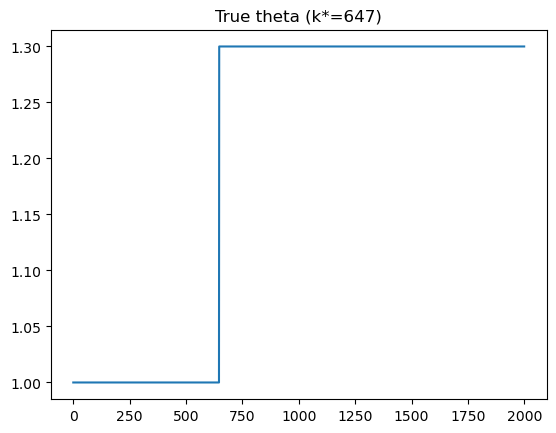

In [5]:

# --- Simulation: T=2000 with random k* and +30% step jump in theta ---

@torch.no_grad()
def simulate_sequence(T: int, dt: float, jump_ratio: float, kstar: int, device, dtype):
    """
    Generates x_true (T,nx), theta_true (T,1), y (T,ny)
    """
    theta0 = 1.0
    theta1 = theta0 * (1.0 + jump_ratio)  # +30% at/after k*
    theta_true = torch.full((T,1), theta0, device=device, dtype=dtype)
    theta_true[kstar:, 0] = theta1

    # initial state
    q0 = torch.tensor([0.2, -0.1], device=device, dtype=dtype)
    v0 = torch.tensor([0.0, 0.0], device=device, dtype=dtype)
    x = torch.cat([q0, v0]).unsqueeze(0)  # (1,4)

    # simulation noises
    Qsim = torch.diag(torch.tensor([1e-6,1e-6,1e-5,1e-5], device=device, dtype=dtype))
    Lsim = torch.linalg.cholesky(Qsim)

    Rsim = torch.diag(torch.tensor([2e-4, 2e-4], device=device, dtype=dtype))
    Lr = torch.linalg.cholesky(Rsim)

    x_true = torch.zeros(T,4, device=device, dtype=dtype)
    y = torch.zeros(T,2, device=device, dtype=dtype)

    for k in range(T):
        th = theta_true[k:k+1]  # (1,1)
        z = torch.cat([x, th], dim=-1)  # (1,5)

        z_next = f_step(z, dt=dt)
        x_next = z_next[:, :4]
        x_next = x_next + (torch.randn(1,4, device=device, dtype=dtype) @ Lsim.T)
        x = x_next

        x_true[k] = x.squeeze(0)
        y[k] = x_true[k, :2] + (torch.randn(2, device=device, dtype=dtype) @ Lr.T)

    return x_true, theta_true, y

def make_p_label(T: int, kstar: int, width: int, device, dtype):
    # label starts at kstar+1 because p_k is predicted from phi up to k-1
    start = min(T-1, kstar + 1)
    end = min(T, start + width)
    p = torch.zeros(T,1, device=device, dtype=dtype)
    p[start:end, 0] = 1.0
    return p

# quick sanity-check visualization of one simulated sequence
device, dtype = cfg.device, cfg.dtype
kstar = random.randint(int(cfg.kstar_lo*cfg.T), int(cfg.kstar_hi*cfg.T))
x_true, theta_true, y = simulate_sequence(cfg.T, cfg.dt, cfg.jump_ratio, kstar, device, dtype)

plt.figure()
plt.plot(theta_true.cpu().numpy())
plt.title(f"True theta (k*={kstar})")
plt.show()


In [6]:


def safe_cholesky(A: torch.Tensor, jitter: float = 1e-6, max_tries: int = 12) -> torch.Tensor:
    """
    Very robust batched Cholesky.

    Strategy:
      1) sanitize + symmetrize
      2) try cholesky_ex with *per-batch* diagonal loading scaled by matrix magnitude
      3) if still failing, repair in float64 by shifting eigenvalues, then cholesky

    Returns L such that (approximately) A ≈ L L^T.
    """
    A = torch.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)
    A = 0.5 * (A + A.transpose(-1, -2))
    B, n, _ = A.shape
    I = torch.eye(n, device=A.device, dtype=A.dtype).unsqueeze(0)

    # Scale-aware base jitter per batch (prevents "too small jitter" when A blows up)
    diag = torch.diagonal(A, dim1=-2, dim2=-1)  # (B,n)
    scale = diag.abs().mean(dim=-1)             # (B,)
    base = jitter * (1.0 + scale)               # (B,)

    # Try increasing diagonal loading
    for i in range(max_tries):
        j = (10.0 ** i) * base                  # (B,)
        Aj = A + j.view(B, 1, 1) * I
        L, info = torch.linalg.cholesky_ex(Aj)
        if (info == 0).all():
            return L

    # Float64 repair path (rare): eigenvalue shift then cholesky
    A64 = A.double()
    I64 = torch.eye(n, device=A.device, dtype=torch.float64).unsqueeze(0)

    w, V = torch.linalg.eigh(A64)
    # clamp eigenvalues, but also apply a global shift if needed
    min_eig = w.min(dim=-1).values             # (B,)
    # Ensure min eigenvalue at least eps64
    eps64 = float(max(jitter, 1e-12))
    shift = torch.clamp(-min_eig + eps64, min=0.0)
    A64 = (V @ torch.diag_embed(torch.clamp(w, min=eps64)) @ V.transpose(-1, -2)) + shift.view(B,1,1) * I64
    A64 = 0.5 * (A64 + A64.transpose(-1, -2))

    L64, info = torch.linalg.cholesky_ex(A64)
    if (info != 0).any():
        # last-resort huge diagonal loading
        big = (10.0 ** max_tries) * base.double()
        A64 = A64 + big.view(B,1,1) * I64
        L64 = torch.linalg.cholesky(A64)

    return L64.to(A.dtype)


# --- Innovation features phi_k = [L^{-1}e, |L^{-1}e|, NIS, logdetS] ---

def make_phi(e: torch.Tensor, S: torch.Tensor, jitter: float = 1e-6,
             clip_e: float = 50.0, clip_phi: float = 50.0) -> torch.Tensor:
    """
    Innovation features phi_k = [e_white, |e_white|, log1p(NIS), logdetS]

    Stabilization:
      - sanitize NaN/Inf
      - robust Cholesky with diagonal loading
      - clip whitened innovation to prevent overflow in NIS
      - use log1p(NIS) to compress heavy tails
      - clip logdetS
    """
    e = torch.nan_to_num(e, nan=0.0, posinf=0.0, neginf=0.0)
    S = torch.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)

    B, ny = e.shape
    I = torch.eye(ny, device=e.device, dtype=e.dtype).unsqueeze(0)
    S = 0.5 * (S + S.transpose(-1, -2)) + jitter * I

    L = safe_cholesky(S, jitter=jitter)  # (B,ny,ny)

    # e_white = L^{-1} e
    e_white = torch.linalg.solve_triangular(L, e.unsqueeze(-1), upper=False).squeeze(-1)
    e_white = torch.clamp(torch.nan_to_num(e_white, nan=0.0, posinf=0.0, neginf=0.0), -clip_e, clip_e)

    nis = (e_white**2).sum(dim=-1, keepdim=True)
    nis = torch.log1p(torch.clamp(torch.nan_to_num(nis, nan=0.0, posinf=0.0, neginf=0.0), 0.0, 1e6))

    diagL = torch.diagonal(L, dim1=-2, dim2=-1)
    diagL = torch.clamp(torch.nan_to_num(diagL, nan=jitter, posinf=jitter, neginf=jitter), min=jitter)
    logdetS = 2.0 * torch.log(diagL).sum(dim=-1, keepdim=True)
    logdetS = torch.clamp(torch.nan_to_num(logdetS, nan=0.0, posinf=0.0, neginf=0.0), -clip_phi, clip_phi)

    phi = torch.cat([e_white, e_white.abs(), nis, logdetS], dim=-1)
    phi = torch.clamp(torch.nan_to_num(phi, nan=0.0, posinf=0.0, neginf=0.0), -clip_phi, clip_phi)
    return phi


In [7]:
# --- Linear algebra helpers for UKF stability ---
# NOTE: `safe_cholesky()` is defined above (with nan/inf sanitization + diagonal loading).
# Here we keep a single `make_spd()` (sanitize + eigenvalue clamp) to avoid accidental overwrites.

def sanitize_sym(A: torch.Tensor) -> torch.Tensor:
    A = torch.nan_to_num(A, nan=0.0, posinf=0.0, neginf=0.0)
    return 0.5 * (A + A.transpose(-1, -2))

def make_spd(A: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """Project a symmetric matrix to SPD by clamping eigenvalues (batched)."""
    A = sanitize_sym(A)
        # For small matrices, float64 eig improves numerical robustness (prevents rare Cholesky failures)
    if A.dtype == torch.float32 and A.shape[-1] <= 10:
        A64 = A.double()
        w, V = torch.linalg.eigh(A64)
        w = torch.clamp(w, min=float(eps))
        A_spd = V @ torch.diag_embed(w) @ V.transpose(-1, -2)
        A_spd = A_spd.to(A.dtype)
    else:
        w, V = torch.linalg.eigh(A)
        w = torch.clamp(w, min=eps)
        A_spd = V @ torch.diag_embed(w) @ V.transpose(-1, -2)
    n = A.shape[-1]
    I = torch.eye(n, device=A.device, dtype=A.dtype)
    return A_spd + eps * I

def sqrtm_spd(A: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """Symmetric sqrt for (approx) SPD matrices via eigendecomposition (robust fallback)."""
    A = sanitize_sym(A)
    w, V = torch.linalg.eigh(A)
    w = torch.clamp(w, min=eps)
    return V @ torch.diag_embed(torch.sqrt(w))


# --- UKF step (batched) ---

def ukf_step(z: torch.Tensor, P: torch.Tensor, y: torch.Tensor, Qz: torch.Tensor, R: torch.Tensor,
            dt: float, alpha: float, beta: float, kappa: float,
            jitter_P: float, jitter_S: float):
    """
    z: (B,nz) mean
    P: (B,nz,nz)
    y: (B,ny)
    Qz: (B,nz,nz)
    R:  (B,ny,ny)
    Returns z_upd, P_upd, innovation e, S
    """
    device, dtype = z.device, z.dtype
    B, nz = z.shape
    ny = y.shape[-1]

    lam = alpha**2 * (nz + kappa) - nz
    c = nz + lam
    Wm0 = lam / c
    Wc0 = Wm0 + (1 - alpha**2 + beta)
    W = 1.0 / (2.0 * c)

    # robust sqrt of P for sigma points
    Pj = make_spd(P, eps=jitter_P)
    U = sqrtm_spd(Pj, eps=jitter_P) * math.sqrt(c)  # (B,nz,nz)

    # sigma points
    sigmas = z.unsqueeze(1).repeat(1, 2*nz+1, 1)
    Ucols = U.transpose(-1, -2)  # each row = a column of U
    sigmas[:, 1:nz+1, :] = z.unsqueeze(1) + Ucols
    sigmas[:, nz+1:,  :] = z.unsqueeze(1) - Ucols

    # propagate through dynamics
    sig_flat = sigmas.reshape(B*(2*nz+1), nz)
    zprop = f_step(sig_flat, dt=dt).reshape(B, 2*nz+1, nz)

    # weights
    wm = torch.full((2*nz+1,), W, device=device, dtype=dtype)
    wc = torch.full((2*nz+1,), W, device=device, dtype=dtype)
    wm[0] = Wm0
    wc[0] = Wc0

    # predicted mean/cov
    z_pred = (zprop * wm.view(1,-1,1)).sum(dim=1)
    dz = zprop - z_pred.unsqueeze(1)
    P_pred = torch.einsum("i,bij,bik->bjk", wc, dz, dz) + Qz

    # predicted measurement
    yprop = h_meas(zprop.reshape(B*(2*nz+1), nz)).reshape(B, 2*nz+1, ny)
    y_pred = (yprop * wm.view(1,-1,1)).sum(dim=1)
    dy = yprop - y_pred.unsqueeze(1)
    S = torch.einsum("i,bij,bik->bjk", wc, dy, dy) + R
    Pzy = torch.einsum("i,bij,bik->bjk", wc, dz, dy)

    # stabilize S (and ensure SPD)
    I_y = torch.eye(ny, device=device, dtype=dtype).unsqueeze(0)
    S = make_spd(S + jitter_S * I_y, eps=jitter_S)

    # gain and update: K = Pzy @ S^{-1} using Cholesky solves
    Ls = safe_cholesky(S, jitter=jitter_S)
    tmp = torch.linalg.solve_triangular(Ls, Pzy.transpose(-1,-2), upper=False)
    tmp = torch.linalg.solve_triangular(Ls.transpose(-1,-2), tmp, upper=True)
    K = tmp.transpose(-1,-2)

    e = y - y_pred
    z_upd = z_pred + torch.einsum("bij,bj->bi", K, e)

    P_upd = P_pred - K @ S @ K.transpose(-1,-2)
    P_upd = make_spd(0.5 * (P_upd + P_upd.transpose(-1,-2)), eps=jitter_P)
    return z_upd, P_upd, e, S

In [8]:

# --- Causal window Transformer NoiseNet ---
# It predicts Qx_k, R_k (full SPD via Cholesky factors) and a change logit p_k.
# It only sees past features (phi up to k-1), so the whole pipeline is causal.

class CausalWindowTransformerNoiseNet(nn.Module):
    def __init__(self, d_in: int, d_model: int, nx: int, ny: int,
                 W: int, n_layers: int, n_heads: int, dropout: float):
        super().__init__()
        self.nx, self.ny = nx, ny
        self.nQ = n_tril(nx)
        self.nR = n_tril(ny)
        self.d_out = self.nQ + self.nR + 1


        self.phi_norm = nn.LayerNorm(d_in)
        self.in_proj = nn.Linear(d_in, d_model)
        self.pos = nn.Parameter(torch.zeros(1, W, d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True, activation="gelu", norm_first=True
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Linear(d_model, self.d_out)

        # initialize to small-ish Q/R (stability)
        with torch.no_grad():
            self.head.weight.mul_(0.01)
            self.head.bias.zero_()
            self.head.bias[:nx] = -6.0               # Q diag logits
            self.head.bias[self.nQ:self.nQ+ny] = -6.0 # R diag logits
            self.head.bias[-1] = -6.0                 # p_logit bias -> p≈0 at init

    def forward(self, phi_seq: torch.Tensor):
        # phi_seq: (B,W,d_in)
        phi_seq = torch.nan_to_num(phi_seq, nan=0.0, posinf=0.0, neginf=0.0)
        phi_seq = torch.clamp(phi_seq, -50.0, 50.0)
        phi_seq = self.phi_norm(phi_seq)

        B, W, _ = phi_seq.shape
        h = self.in_proj(phi_seq) + self.pos[:, :W, :]
        h = self.enc(h)
        out = self.head(h[:, -1, :])  # last token as "current" prediction
        out = torch.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)

        qv = out[:, :self.nQ]
        rv = out[:, self.nQ:self.nQ+self.nR]
        p_logit = out[:, -1:].clamp(-20.0, 20.0)
        return qv, rv, p_logit



In [9]:

# --- Dataset creation (in-memory): random k* per sequence ---
# --- 데이터 저장 경로 설정 ---
DATA_DIR = "./data"
os.makedirs(DATA_DIR, exist_ok=True)

TRAIN_FILE = os.path.join(DATA_DIR, "train_data.pt")
VAL_FILE = os.path.join(DATA_DIR, "val_data.pt")
TEST_FILE = os.path.join(DATA_DIR, "test_data.pt")

@torch.no_grad()
def build_dataset(n_seq: int, cfg: CFG):
    dev, dt = cfg.device, cfg.dtype
    data = []
    for _ in range(n_seq):
        kstar = random.randint(int(cfg.kstar_lo * cfg.T), int(cfg.kstar_hi * cfg.T))
        x_true, theta_true, y = simulate_sequence(cfg.T, cfg.dt, cfg.jump_ratio, kstar, dev, dt)
        p = make_p_label(cfg.T, kstar, cfg.p_label_width, dev, dt)
        data.append({"x_true": x_true, "theta_true": theta_true, "y": y, "p": p, "kstar": kstar})
    return data

def sample_batch(data, cfg: CFG, balanced: bool = True):
    """
    Samples B segments of length seg=burn_in+L.

    Why 'balanced':
      p labels are sparse (only around k*). Pure random cropping often yields
      batches with *no positives inside the LOSS window*, which makes BCE learning
      unstable / degenerate.

    Strategy:
      With probability cfg.p_event_frac, choose the crop so that the label start
      (k*+1) lands inside the LOSS region (after burn_in), near a target location.
      Otherwise sample uniformly at random.
    """
    B = cfg.batch_size
    T = cfg.T
    seg = cfg.burn_in + cfg.L
    idx = random.sample(range(len(data)), B)
    s_max = T - seg - 1

    y, x, p = [], [], []
    starts = []
    for i in idx:
        d = data[i]
        if balanced and (random.random() < cfg.p_event_frac):
            kstar = int(d["kstar"])
            # label starts at kstar+1; we want that to be inside the LOSS region [burn_in, burn_in+L)
            target = cfg.burn_in + int(cfg.p_event_target_in_loss * cfg.L)
            s = (kstar + 1) - target + random.randint(-cfg.p_event_jitter, cfg.p_event_jitter)
            s = max(0, min(s_max, s))
        else:
            s = random.randint(0, s_max)
        starts.append(s)

        y.append(d["y"][s:s+seg])
        x.append(d["x_true"][s:s+seg])
        p.append(d["p"][s:s+seg])

    return torch.stack(y, 0), torch.stack(x, 0), torch.stack(p, 0)

def prepare_datasets(cfg, force_generate=False):
    """
    데이터 파일이 있으면 로드하고, 없으면 생성 후 저장합니다.
    force_generate=True로 설정하면 무조건 새로 생성하고 덮어씁니다.
    """
    # 1. 파일이 모두 존재하고, 강제 생성이 아닐 경우 -> 로드
    if os.path.exists(TRAIN_FILE) and os.path.exists(VAL_FILE) and os.path.exists(TEST_FILE) and not force_generate:
        print(f"Loading datasets from {DATA_DIR}...")
        train_data = torch.load(TRAIN_FILE)
        val_data = torch.load(VAL_FILE)
        test_data = torch.load(TEST_FILE)
        print("Data loaded successfully.")
    
    # 2. 파일이 없거나 강제 생성일 경우 -> 생성 및 저장
    else:
        print("Generating new datasets...")
        # (1) Training Data
        print(f"  - Building Train ({cfg.n_train_seq} seq)...")
        train_data = build_dataset(cfg.n_train_seq, cfg)
        
        # (2) Validation Data
        print(f"  - Building Val ({cfg.n_val_seq} seq)...")
        val_data = build_dataset(cfg.n_val_seq, cfg)
        
        # (3) Testing Data (새로 추가됨)
        print(f"  - Building Test ({cfg.n_test_seq} seq)...")
        test_data = build_dataset(cfg.n_test_seq, cfg)
        
        # 저장
        print(f"Saving datasets to {DATA_DIR}...")
        torch.save(train_data, TRAIN_FILE)
        torch.save(val_data, VAL_FILE)
        torch.save(test_data, TEST_FILE)
        print("Data generation and saving complete.")
        
    return train_data, val_data, test_data

# --- 실행 ---
# force_generate=True로 하면 기존 파일을 무시하고 새로 만듭니다.
train_data, val_data, test_data = prepare_datasets(cfg, force_generate=True)

print(f"Dataset Sizes -> Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Generating new datasets...
  - Building Train (128 seq)...
  - Building Val (32 seq)...
  - Building Test (32 seq)...
Saving datasets to ./data...
Data generation and saving complete.
Dataset Sizes -> Train: 128, Val: 32, Test: 32


In [10]:
# --- Differentiable rollout on one (burn-in + loss) window ---

def _nll_gaussian_from_chol(resid: torch.Tensor, L: torch.Tensor, clip_quad: float = 1e6) -> torch.Tensor:
    """
    resid: (B,d), L: (B,d,d) lower Cholesky of SPD cov
    returns per-sample NLL up to an additive constant (drops d*log(2pi)/2).

    Stabilization:
      - sanitize NaN/Inf
      - clamp quadratic form to avoid Inf -> NaN in later ops
      - clamp logdet contribution
    """
    resid = torch.nan_to_num(resid, nan=0.0, posinf=0.0, neginf=0.0)
    L = torch.nan_to_num(L, nan=0.0, posinf=0.0, neginf=0.0)

    sol = torch.cholesky_solve(resid.unsqueeze(-1), L)  # (B,d,1)
    sol = torch.nan_to_num(sol, nan=0.0, posinf=0.0, neginf=0.0)

    quad = (resid.unsqueeze(1) @ sol).squeeze(-1).squeeze(-1)  # (B,)
    quad = torch.clamp(torch.nan_to_num(quad, nan=0.0, posinf=clip_quad, neginf=0.0), 0.0, clip_quad)

    diagL = torch.diagonal(L, dim1=-2, dim2=-1)
    diagL = torch.clamp(torch.nan_to_num(diagL, nan=1e-6, posinf=1e-6, neginf=1e-6), min=1e-6)
    logdet = 2.0 * torch.log(diagL).sum(dim=-1)  # (B,)
    logdet = torch.clamp(torch.nan_to_num(logdet, nan=0.0, posinf=0.0, neginf=0.0), -100.0, 100.0)

    return 0.5 * (quad + logdet)
def rollout_window(net: nn.Module, y_seg: torch.Tensor, x_true_seg: torch.Tensor, p_label_seg: torch.Tensor, cfg: CFG):
    """
    y_seg: (B,Tseg,ny), x_true_seg: (B,Tseg,nx), p_label_seg: (B,Tseg,1)
    Returns dict(losses, trajectories)
    """
    device, dtype = y_seg.device, y_seg.dtype
    B, Tseg, ny = y_seg.shape
    nx, nz = cfg.nx, cfg.nz

    d_in = 2*ny + 2

    # init z and P
    q0 = y_seg[:, 0, :]
    v0 = torch.zeros(B,2, device=device, dtype=dtype)
    theta0 = torch.ones(B,1, device=device, dtype=dtype)
    z = torch.cat([q0, v0, theta0], dim=-1)

    P = torch.diag(torch.tensor([1e-2,1e-2, 1e-1,1e-1, 1e-2], device=device, dtype=dtype)).unsqueeze(0).repeat(B,1,1)

    # feature buffer: past-only features
    phi_buf = torch.zeros(B, cfg.W, d_in, device=device, dtype=dtype)

    xhat, thetahat, ppred = [], [], []
    qv_hist, rv_hist = [], []
    nll_y_hist, nll_x_hist = [], []

    for t in range(Tseg):
        # 1) predict Qx_k, R_k, p_k from past feature window
        qv, rv, p_logit = net(phi_buf)
        p = torch.sigmoid(p_logit)

        # 2) build full SPD Qx and R via Cholesky
        Lq = vec_to_cholesky(qv, nx)
        Qx = chol_to_spd(Lq)
        Qx = make_spd(torch.nan_to_num(Qx, nan=0.0, posinf=0.0, neginf=0.0), eps=cfg.jitter_P)
        Lr = vec_to_cholesky(rv, ny)
        R = chol_to_spd(Lr)
        R = make_spd(torch.nan_to_num(R, nan=0.0, posinf=0.0, neginf=0.0), eps=cfg.jitter_S)

        # 3) gate Q_theta,k using p_k (THIS is the key location)
        qtheta = (1.0 - p) * cfg.Qtheta_base + p * cfg.Qtheta_jump
        Qt = qtheta.view(B,1,1)
        Qz = blockdiag(Qx, Qt)

        # 4) UKF update
        z, P, e, S = ukf_step(
            z, P, y_seg[:, t, :], Qz, R,
            dt=cfg.dt, alpha=cfg.alpha, beta=cfg.beta, kappa=cfg.kappa,
            jitter_P=cfg.jitter_P, jitter_S=cfg.jitter_S
        )

        # 4b) probabilistic losses (no theta supervision; uses y and x GT only)
        # innovation NLL calibrates S (and indirectly R, Q, P)
        Ls = safe_cholesky(S, jitter=cfg.jitter_S)
        nll_y = _nll_gaussian_from_chol(e, Ls)  # (B,)
        nll_y_hist.append(nll_y)

        # state NLL calibrates Px (optional but recommended)
        Px = P[:, :nx, :nx]
        dx = x_true_seg[:, t, :] - z[:, :nx]
        Lx = safe_cholesky(Px, jitter=cfg.jitter_P)
        nll_x = _nll_gaussian_from_chol(dx, Lx)
        nll_x_hist.append(nll_x)

        # 5) create phi_t and append to buffer (for next step)
        phi_t = make_phi(e, S, jitter=cfg.jitter_S)
        phi_buf = torch.cat([phi_buf[:, 1:, :], phi_t.unsqueeze(1)], dim=1)

        xhat.append(z[:, :nx])
        thetahat.append(z[:, nx:nx+1])
        ppred.append(p_logit)
        qv_hist.append(qv)
        rv_hist.append(rv)

    xhat = torch.stack(xhat, 1)
    thetahat = torch.stack(thetahat, 1)
    ppred = torch.stack(ppred, 1)
    ppred = torch.nan_to_num(ppred, nan=0.0, posinf=0.0, neginf=0.0).clamp(-20.0, 20.0)

    qv_hist = torch.stack(qv_hist, 1)
    rv_hist = torch.stack(rv_hist, 1)
    nll_y_hist = torch.stack(nll_y_hist, 1)  # (B,Tseg)
    nll_x_hist = torch.stack(nll_x_hist, 1)

    start = cfg.burn_in
    end = cfg.burn_in + cfg.L

    x_loss = F.smooth_l1_loss(xhat[:, start:end, :], x_true_seg[:, start:end, :])  # robust vs outliers
    nll_y = nll_y_hist[:, start:end].mean()
    nll_x = nll_x_hist[:, start:end].mean()
    p_label = torch.nan_to_num(p_label_seg[:, start:end, :], nan=0.0, posinf=0.0, neginf=0.0).clamp(0.0, 1.0)

    # ---- Balanced BCE (pos_weight) to handle sparse change labels ----
    logits = ppred[:, start:end, :]
    pos = p_label.sum()
    neg = p_label.numel() - pos
    pos_rate = (pos / (p_label.numel() + 1e-12)).detach()

    if cfg.bce_use_pos_weight and (pos > 0) and (neg > 0):
        pw = torch.clamp(neg / (pos + 1e-6), 1.0, cfg.bce_posw_max)
        pw = torch.tensor([float(pw.detach())], device=device, dtype=dtype)
        bce = F.binary_cross_entropy_with_logits(logits, p_label, pos_weight=pw)
    else:
        bce = F.binary_cross_entropy_with_logits(logits, p_label)

    dq = (qv_hist[:, start+1:end, :] - qv_hist[:, start:end-1, :]).pow(2).mean()
    dr = (rv_hist[:, start+1:end, :] - rv_hist[:, start:end-1, :]).pow(2).mean()
    smooth = dq + dr

    q_off = qv_hist[:, start:end, nx:]
    r_off = rv_hist[:, start:end, ny:]
    offdiag = (q_off.pow(2).mean() + r_off.pow(2).mean())

    loss = (
        cfg.w_state*x_loss
        + cfg.w_nll_y*nll_y
        + cfg.w_nll_x*nll_x
        + cfg.w_bce*bce
        + cfg.w_smooth*smooth
        + cfg.w_offdiag*offdiag
    )

    return {
        "loss": loss,
        "x_loss": x_loss.detach(),
        "nll_y": nll_y.detach(),
        "nll_x": nll_x.detach(),
        "bce": bce.detach(),
        "smooth": smooth.detach(),
        "offdiag": offdiag.detach(),
        "xhat": xhat.detach(),
        "thetahat": thetahat.detach(),
        "ppred": ppred.detach(),
    }


In [ ]:
# ============================================================
# DEBUG CELL: Catch the first NaN/Inf during rollout and print
#             the exact step + batch element + key diagnostics.
# ------------------------------------------------------------
# Usage (run this cell BEFORE training cell):
#   enable_debug_rollout(stop_on_nan=True)
#   # then run the training cell as-is
# To disable:
#   disable_debug_rollout()
# ============================================================

import math
from typing import Optional, Dict, Any

def _tensor_stats(x: torch.Tensor) -> Dict[str, Any]:
    x = x.detach()
    finite = torch.isfinite(x)
    frac = float(finite.float().mean().cpu())
    stats = {
        "shape": tuple(x.shape),
        "dtype": str(x.dtype),
        "frac_finite": frac,
    }
    if finite.any():
        xf = x[finite]
        stats.update({
            "min": float(xf.min().cpu()),
            "max": float(xf.max().cpu()),
            "mean": float(xf.mean().cpu()),
            "std": float(xf.std().cpu()) if xf.numel() > 1 else 0.0,
        })
    else:
        stats.update({"min": float("nan"), "max": float("nan"), "mean": float("nan"), "std": float("nan")})
    return stats

def _first_bad_batch(x: torch.Tensor) -> Optional[int]:
    """Return first batch index whose entries contain non-finite values, else None."""
    if x.ndim == 0:
        return 0 if (not torch.isfinite(x)) else None
    if x.shape[0] == 0:
        return None
    finite = torch.isfinite(x)
    per_b = finite.view(finite.shape[0], -1).all(dim=1)
    bad = (~per_b).nonzero(as_tuple=False)
    return int(bad[0].item()) if bad.numel() > 0 else None

def _print_diag(name: str, x: torch.Tensor, b: int):
    print(f"{name} (batch {b}) diag:", torch.diagonal(x[b], dim1=-2, dim2=-1).detach().cpu().numpy())

def _print_eigs(name: str, A: torch.Tensor, b: int):
    Ab = 0.5*(A[b] + A[b].transpose(-1,-2))
    w = torch.linalg.eigvalsh(Ab).detach().cpu().numpy()
    print(f"{name} (batch {b}) eigs:", w)

def _debug_abort(msg: str):
    print("========== DEBUG ABORT ==========")
    print(msg)
    print("=================================")
    raise FloatingPointError(msg)

def rollout_window_debug(net: nn.Module,
                         y_seg: torch.Tensor,
                         x_true_seg: torch.Tensor,
                         p_label_seg: torch.Tensor,
                         cfg: CFG,
                         stop_on_nan: bool = True,
                         plogit_clip: float = 20.0,
                         ewhite_clip: float = 100.0,
                         phi_clip: float = 1e4):
    """
    Debug version of rollout_window: prints diagnostics at first sign of NaN/Inf.
    Intended for short runs / one mini-batch to locate the failure source.
    """
    device, dtype = y_seg.device, y_seg.dtype
    B, Tseg, ny = y_seg.shape
    nx, nz = cfg.nx, cfg.nz

    d_in = 2*ny + 2

    # init z and P
    q0 = y_seg[:, 0, :]
    v0 = torch.zeros(B,2, device=device, dtype=dtype)
    theta0 = torch.ones(B,1, device=device, dtype=dtype)
    z = torch.cat([q0, v0, theta0], dim=-1)

    P = torch.diag(torch.tensor([1e-2,1e-2, 1e-1,1e-1, 1e-2], device=device,
                                dtype=dtype)).unsqueeze(0).repeat(B,1,1)

    phi_buf = torch.zeros(B, cfg.W, d_in, device=device, dtype=dtype)

    xhat, thetahat, ppred = [], [], []
    qv_hist, rv_hist = [], []
    nll_y_hist, nll_x_hist = [], []

    for t in range(Tseg):
        # ---- Net forward ----
        if not torch.isfinite(phi_buf).all():
            b = _first_bad_batch(phi_buf)
            print(f"[DEBUG] non-finite phi_buf BEFORE net at t={t}, b={b}")
            print("phi_buf stats:", _tensor_stats(phi_buf))
            if b is not None:
                # print a few entries
                print("phi_buf[b, -1, :]:", phi_buf[b, -1, :].detach().cpu().numpy())
            if stop_on_nan:
                _debug_abort("phi_buf became non-finite before net forward.")

        qv, rv, p_logit = net(phi_buf)

        b_bad = _first_bad_batch(p_logit)
        if (not torch.isfinite(qv).all()) or (not torch.isfinite(rv).all()) or (b_bad is not None):
            b = b_bad if b_bad is not None else (_first_bad_batch(qv) or _first_bad_batch(rv) or 0)
            print(f"[DEBUG] non-finite net output at t={t}, b={b}")
            print("qv stats:", _tensor_stats(qv))
            print("rv stats:", _tensor_stats(rv))
            print("p_logit stats:", _tensor_stats(p_logit))
            print("phi_buf stats:", _tensor_stats(phi_buf))
            if stop_on_nan:
                _debug_abort("net output became non-finite.")

        # sanitize p_logit to avoid BCE NaNs during debugging
        p_logit = torch.nan_to_num(p_logit, nan=0.0, posinf=0.0, neginf=0.0).clamp(-plogit_clip, plogit_clip)
        p = torch.sigmoid(p_logit)

        # ---- Build Qx, R ----
        Lq = vec_to_cholesky(qv, nx)
        Qx = chol_to_spd(Lq)
        Lr = vec_to_cholesky(rv, ny)
        R = chol_to_spd(Lr)

        if (not torch.isfinite(Qx).all()) or (not torch.isfinite(R).all()):
            b = _first_bad_batch(Qx) or _first_bad_batch(R) or 0
            print(f"[DEBUG] non-finite Q/R at t={t}, b={b}")
            print("Qx stats:", _tensor_stats(Qx))
            print("R stats:", _tensor_stats(R))
            if stop_on_nan:
                _debug_abort("Qx or R became non-finite.")

        # ---- Gate Q_theta ----
        qtheta = (1.0 - p) * cfg.Qtheta_base + p * cfg.Qtheta_jump
        Qt = qtheta.view(B,1,1)
        Qz = blockdiag(Qx, Qt)

        if not torch.isfinite(Qz).all():
            b = _first_bad_batch(Qz) or 0
            print(f"[DEBUG] non-finite Qz at t={t}, b={b}")
            print("p stats:", _tensor_stats(p))
            print("qtheta stats:", _tensor_stats(qtheta))
            print("Qz stats:", _tensor_stats(Qz))
            if stop_on_nan:
                _debug_abort("Qz became non-finite.")

        # ---- UKF step ----
        z, P, e, S = ukf_step(
            z, P, y_seg[:, t, :], Qz, R,
            dt=cfg.dt, alpha=cfg.alpha, beta=cfg.beta, kappa=cfg.kappa,
            jitter_P=cfg.jitter_P, jitter_S=cfg.jitter_S
        )

        if (not torch.isfinite(z).all()) or (not torch.isfinite(P).all()) or (not torch.isfinite(e).all()) or (not torch.isfinite(S).all()):
            b = _first_bad_batch(z) or _first_bad_batch(P) or _first_bad_batch(e) or _first_bad_batch(S) or 0
            print(f"[DEBUG] non-finite UKF outputs at t={t}, b={b}")
            print("z stats:", _tensor_stats(z))
            print("P stats:", _tensor_stats(P))
            print("e stats:", _tensor_stats(e))
            print("S stats:", _tensor_stats(S))
            _print_diag("S", S, b); _print_eigs("S", S, b)
            _print_diag("P", P, b); _print_eigs("P", P, b)
            if stop_on_nan:
                _debug_abort("UKF outputs became non-finite.")

        # ---- key diagnostics for stability ----
        # min eigs
        b = 0
        try:
            wS = torch.linalg.eigvalsh(0.5*(S + S.transpose(-1,-2)))
            wP = torch.linalg.eigvalsh(0.5*(P + P.transpose(-1,-2)))
            minS = float(wS.min().detach().cpu())
            minP = float(wP.min().detach().cpu())
        except Exception:
            minS, minP = float("nan"), float("nan")

        # e_white magnitude
        Ls = safe_cholesky(S, jitter=cfg.jitter_S)
        e_white = torch.linalg.solve_triangular(Ls, e.unsqueeze(-1), upper=False).squeeze(-1)
        e_white = torch.nan_to_num(e_white, nan=0.0, posinf=0.0, neginf=0.0).clamp(-ewhite_clip, ewhite_clip)
        max_ew = float(e_white.abs().max().detach().cpu())
        nis = (e_white**2).sum(dim=-1)  # (B,)
        max_nis = float(nis.max().detach().cpu())

        # ---- probabilistic losses ----
        nll_y = _nll_gaussian_from_chol(e, Ls)
        Px = P[:, :nx, :nx]
        dx = x_true_seg[:, t, :] - z[:, :nx]
        Lx = safe_cholesky(Px, jitter=cfg.jitter_P)
        nll_x = _nll_gaussian_from_chol(dx, Lx)

        if (not torch.isfinite(nll_y).all()) or (not torch.isfinite(nll_x).all()):
            b = _first_bad_batch(nll_y) or _first_bad_batch(nll_x) or 0
            print(f"[DEBUG] non-finite NLL at t={t}, b={b}")
            print("nll_y stats:", _tensor_stats(nll_y))
            print("nll_x stats:", _tensor_stats(nll_x))
            print(f"min_eig(S)={minS:.3e}, min_eig(P)={minP:.3e}, max|e_white|={max_ew:.3e}, max NIS={max_nis:.3e}")
            _print_diag("S", S, b); _print_eigs("S", S, b)
            if stop_on_nan:
                _debug_abort("NLL became non-finite.")

        nll_y_hist.append(nll_y)
        nll_x_hist.append(nll_x)

        # ---- phi update ----
        phi_t = make_phi(e, S, jitter=cfg.jitter_S)
        if not torch.isfinite(phi_t).all():
            b = _first_bad_batch(phi_t) or 0
            print(f"[DEBUG] non-finite phi_t at t={t}, b={b}")
            print("phi_t stats:", _tensor_stats(phi_t))
            print(f"min_eig(S)={minS:.3e}, min_eig(P)={minP:.3e}, max|e_white|={max_ew:.3e}, max NIS={max_nis:.3e}")
            _print_diag("S", S, b); _print_eigs("S", S, b)
            if stop_on_nan:
                _debug_abort("phi_t became non-finite.")

        # optional: clamp phi_t to avoid propagating extreme values while debugging
        phi_t = torch.nan_to_num(phi_t, nan=0.0, posinf=0.0, neginf=0.0).clamp(-phi_clip, phi_clip)

        phi_buf = torch.cat([phi_buf[:, 1:, :], phi_t.unsqueeze(1)], dim=1)

        # store
        xhat.append(z[:, :nx])
        thetahat.append(z[:, nx:nx+1])
        ppred.append(p_logit)
        qv_hist.append(qv)
        rv_hist.append(rv)

        # lightweight periodic info (optional)
        if t == 0 or (t % 50 == 0):
            print(f"[DEBUG t={t}] min_eig(S)={minS:.3e}, min_eig(P)={minP:.3e}, max|e_white|={max_ew:.3e}, max NIS={max_nis:.3e}, "
                  f"p in [{float(p.min()):.3e},{float(p.max()):.3e}]")

    # Finish as original
    xhat = torch.stack(xhat, 1)
    thetahat = torch.stack(thetahat, 1)
    ppred = torch.stack(ppred, 1)

    start = cfg.burn_in
    end = cfg.burn_in + cfg.L

    x_loss = F.mse_loss(xhat[:, start:end, :], x_true_seg[:, start:end, :])
    nll_y = torch.stack(nll_y_hist, 1)[:, start:end].mean()
    nll_x = torch.stack(nll_x_hist, 1)[:, start:end].mean()
    bce = F.binary_cross_entropy_with_logits(ppred[:, start:end, :], p_label_seg[:, start:end, :])

    loss = cfg.w_state*x_loss + cfg.w_nll_y*nll_y + cfg.w_nll_x*nll_x + cfg.w_bce*bce
    return {"loss": loss, "x_loss": x_loss, "nll_y": nll_y, "nll_x": nll_x, "bce": bce,
            "xhat": xhat, "thetahat": thetahat, "ppred": ppred}

# --- Monkey-patch helpers (optional) ---
_rollout_window_original = None

def enable_debug_rollout(stop_on_nan: bool = True):
    """
    After calling this, any call to rollout_window(...) will use rollout_window_debug(...).
    """
    global rollout_window, _rollout_window_original
    if _rollout_window_original is None:
        _rollout_window_original = rollout_window
    def _patched(net, y_seg, x_true_seg, p_label_seg, cfg):
        return rollout_window_debug(net, y_seg, x_true_seg, p_label_seg, cfg, stop_on_nan=stop_on_nan)
    rollout_window = _patched
    print("✅ Debug rollout enabled. (rollout_window has been patched)")

def disable_debug_rollout():
    global rollout_window, _rollout_window_original
    if _rollout_window_original is not None:
        rollout_window = _rollout_window_original
        _rollout_window_original = None
        print("✅ Debug rollout disabled. (rollout_window restored)")
    else:
        print("Debug rollout was not enabled.")

In [ ]:

# --- Train ---

torch.manual_seed(0)
random.seed(0)

d_in = 2*cfg.ny + 2
net = CausalWindowTransformerNoiseNet(
    d_in=d_in, d_model=cfg.d_model, nx=cfg.nx, ny=cfg.ny,
    W=cfg.W, n_layers=cfg.n_layers, n_heads=cfg.n_heads, dropout=cfg.dropout
).to(cfg.device)

# Sanity-check: p_logit bias and initial p
with torch.no_grad():
    print('init head.bias[-1] (p_logit):', float(net.head.bias[-1].detach().cpu()))
    dummy_phi = torch.zeros(1, cfg.W, d_in, device=cfg.device, dtype=cfg.dtype)
    _, _, p0 = net(dummy_phi)
    print('init p (sigmoid):', float(torch.sigmoid(p0)[0,0].detach().cpu()))

opt = torch.optim.AdamW(net.parameters(), lr=cfg.lr, weight_decay=1e-4)

for ep in range(cfg.epochs):
    net.train()
    loss_sum = x_sum = bce_sum = nly_sum = nlx_sum = 0.0
    posrate_sum = 0.0
    pmean_sum = 0.0

    for it in range(cfg.steps_per_epoch):
        y_seg, x_seg, p_seg = sample_batch(train_data, cfg, balanced=True)
        pos_rate = float(p_seg[:, cfg.burn_in:cfg.burn_in+cfg.L, :].mean().detach().cpu())
        out = rollout_window(net, y_seg, x_seg, p_seg, cfg)

        # Skip catastrophic batches (often from a bad crop right on the jump + unstable covariances)
        if float(out['loss'].detach()) > cfg.skip_loss_thresh:
            print(f"[warn] huge loss at ep {ep+1} it {it+1}: {float(out['loss']):.3e} (pos_rate={pos_rate:.3f})")
            opt.zero_grad(set_to_none=True)
            continue

        # Skip non-finite batches to avoid optimizer poisoning
        if (not torch.isfinite(out['loss']).all()) or (not torch.isfinite(out['bce']).all()):
            print(f"[warn] non-finite loss at ep {ep+1} it {it+1}: loss={out['loss'].detach().cpu().numpy()}, bce={out['bce'].detach().cpu().numpy()}")
            opt.zero_grad(set_to_none=True)
            continue

        opt.zero_grad(set_to_none=True)
        out["loss"].backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        opt.step()

        loss_sum += float(out["loss"].detach())
        x_sum += float(out["x_loss"])
        bce_sum += float(out["bce"])
        nly_sum += float(out["nll_y"])
        nlx_sum += float(out["nll_x"])
        posrate_sum += pos_rate
        # optional: monitor mean predicted p on this batch window
        if 'ppred' in out:
            pmean_sum += float(torch.sigmoid(out['ppred'][:, cfg.burn_in:cfg.burn_in+cfg.L, :]).mean().detach())

    net.eval()
    with torch.no_grad():
        yv, xv, pv = sample_batch(val_data, cfg, balanced=False)
        outv = rollout_window(net, yv, xv, pv, cfg)

    print(f"[ep {ep+1}/{cfg.epochs}] "
          f"train loss {loss_sum/cfg.steps_per_epoch:.4f} (x {x_sum/cfg.steps_per_epoch:.4f}, bce {bce_sum/cfg.steps_per_epoch:.4f}) | "
          f"val loss {float(outv['loss']):.4f} (x {float(outv['x_loss']):.4f}, bce {float(outv['bce']):.4f}) | train pos_rate {posrate_sum/cfg.steps_per_epoch:.3f} | train p_mean {pmean_sum/cfg.steps_per_epoch:.3f}")


C:\Users\minhy\AppData\Local\Temp\ipykernel_9740\1310868581.py:21: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)


In [ ]:
import pandas as pd

# --- Full 2000-step rollout + probabilistic evaluation (theta GT used ONLY here) ---

@torch.no_grad()
def rollout_full(net: nn.Module, y: torch.Tensor, cfg: CFG):
    """
    y: (T,ny)
    returns:
      zhat: (T,nz)
      P:    (T,nz,nz)
      p:    (T,1)  change probability
      nis:  (T,1)  normalized innovation squared (should average ~ ny)
    """
    device, dtype = cfg.device, cfg.dtype
    T = y.shape[0]
    ny, nx, nz = cfg.ny, cfg.nx, cfg.nz
    d_in = 2*ny + 2

    q0 = y[0:1, :]
    v0 = torch.zeros(1,2, device=device, dtype=dtype)
    theta0 = torch.ones(1,1, device=device, dtype=dtype)
    z = torch.cat([q0, v0, theta0], dim=-1)

    P = torch.diag(torch.tensor([1e-2,1e-2, 1e-1,1e-1, 1e-2], device=device, dtype=dtype)).unsqueeze(0)
    phi_buf = torch.zeros(1, cfg.W, d_in, device=device, dtype=dtype)

    zhist = torch.zeros(T, nz, device=device, dtype=dtype)
    Phist = torch.zeros(T, nz, nz, device=device, dtype=dtype)
    p = torch.zeros(T, 1, device=device, dtype=dtype)
    nis = torch.zeros(T, 1, device=device, dtype=dtype)

    for t in range(T):
        qv, rv, p_logit = net(phi_buf)
        p_logit = torch.nan_to_num(p_logit, nan=0.0, posinf=0.0, neginf=0.0).clamp(-20.0, 20.0)
        p_t = torch.sigmoid(p_logit)

        Lq = vec_to_cholesky(qv, nx)
        Qx = chol_to_spd(Lq)
        Lr = vec_to_cholesky(rv, ny)
        R = chol_to_spd(Lr)

        qtheta = (1.0 - p_t) * cfg.Qtheta_base + p_t * cfg.Qtheta_jump
        Qt = qtheta.view(1,1,1)
        Qz = blockdiag(Qx, Qt)

        z, P, e, S = ukf_step(
            z, P, y[t:t+1, :], Qz, R,
            dt=cfg.dt, alpha=cfg.alpha, beta=cfg.beta, kappa=cfg.kappa,
            jitter_P=cfg.jitter_P, jitter_S=cfg.jitter_S
        )

        # NIS = e^T S^{-1} e
        Ls = safe_cholesky(S, jitter=cfg.jitter_S)
        sol = torch.cholesky_solve(e.unsqueeze(-1), Ls)
        quad = (e.unsqueeze(1) @ sol).squeeze(-1).squeeze(-1)  # (1,)
        nis[t, 0] = quad[0]

        phi_t = make_phi(e, S, jitter=cfg.jitter_S)
        phi_buf = torch.cat([phi_buf[:, 1:, :], phi_t.unsqueeze(1)], dim=1)

        zhist[t] = z[0]
        Phist[t] = P[0]
        p[t] = p_t[0]

    return zhist, Phist, p, nis


def _z_for_level(level: float) -> float:
    # two-sided central interval
    if level == 0.50: return 0.67448975
    if level == 0.90: return 1.64485363
    if level == 0.95: return 1.95996398
    if level == 0.99: return 2.57582930
    raise ValueError("Unsupported level")

@torch.no_grad()
def evaluate_one(net: nn.Module, d: dict, cfg: CFG, levels=(0.50, 0.90, 0.99)):
    y = d["y"]
    x_true = d["x_true"]
    theta_true = d["theta_true"]
    p_label = d["p"]
    kstar = d["kstar"]

    zhat, Phist, p, nis = rollout_full(net, y, cfg)
    nx = cfg.nx

    xhat = zhat[:, :nx]
    thetahat = zhat[:, nx:nx+1]

    # diag variances
    Pxx = torch.diagonal(Phist[:, :nx, :nx], dim1=-2, dim2=-1)  # (T,nx)
    Ptt = Phist[:, nx, nx].unsqueeze(-1)                        # (T,1)

    # point errors
    ex = xhat - x_true
    et = thetahat - theta_true

    rmse_x = torch.sqrt((ex**2).mean()).item()
    rmse_theta = torch.sqrt((et**2).mean()).item()

    # coverage (componentwise marginal)
    cov = {}
    for lv in levels:
        zc = _z_for_level(lv)
        cov[f"x@{int(lv*100)}"] = (ex.abs() <= zc*torch.sqrt(Pxx)).float().mean().item()
        cov[f"theta@{int(lv*100)}"] = (et.abs() <= zc*torch.sqrt(Ptt)).float().mean().item()

    # NEES (z) and NEES_theta (consistency checks for P)
    dz = torch.cat([ex, et], dim=-1)  # (T,nz)
    Lz = safe_cholesky(Phist, jitter=cfg.jitter_P)  # (T,nz,nz)
    solz = torch.cholesky_solve(dz.unsqueeze(-1), Lz)  # (T,nz,1)
    quadz = (dz.unsqueeze(1) @ solz).squeeze(-1).squeeze(-1)  # (T,)
    nees = quadz.mean().item()
    nees_theta = float(((et[:,0]**2) / (Ptt[:,0] + 1e-12)).mean().item())

    # NIS mean
    nis_mean = nis.mean().item()

    # change detection metrics (AUC + first-detect delay)
    # AUC via Mann-Whitney (no sklearn dependency)
    y_true = p_label[:,0].detach().cpu().numpy().astype(np.int32)
    y_score = p[:,0].detach().cpu().numpy()
    n_pos = int(y_true.sum())
    n_neg = int((1 - y_true).sum())
    if n_pos == 0 or n_neg == 0:
        auc = float("nan")
    else:
        order = np.argsort(y_score)
        ranks = np.empty_like(order, dtype=np.float64)
        ranks[order] = np.arange(len(y_score), dtype=np.float64) + 1.0
        sum_ranks_pos = ranks[y_true == 1].sum()
        auc = (sum_ranks_pos - n_pos*(n_pos+1)/2.0) / (n_pos*n_neg)

    # detection delay after k* (thresholded)
    thr = 0.5
    after = np.where(np.arange(cfg.T) >= kstar)[0]
    det_idx = after[np.where(y_score[after] >= thr)[0]]
    det_delay = int(det_idx[0] - kstar) if det_idx.size > 0 else None

    return {
        "kstar": kstar,
        "rmse_x": rmse_x,
        "rmse_theta": rmse_theta,
        "nees_mean": nees,
        "nees_theta_mean": nees_theta,
        "nis_mean": nis_mean,
        "auc_p": float(auc),
        "det_delay": det_delay,
        **cov
    }, (zhat, Phist, p, nis)


# --- Example: visualize one test sequence ---
d = random.choice(test_data)
metrics, (zhat, Phist, p, nis) = evaluate_one(net, d, cfg)

kstar = d["kstar"]
x_true = d["x_true"]
theta_true = d["theta_true"]
nx = cfg.nx

xhat = zhat[:, :nx]
thetahat = zhat[:, nx:nx+1]
Ptt = Phist[:, nx, nx].unsqueeze(-1)

print("One-sequence metrics:")
for k,v in metrics.items():
    print(f"  {k}: {v}")

# plot theta with 99% band around k*
z99 = _z_for_level(0.99)
theta_std = torch.sqrt(Ptt + 1e-12)

w = 250
a = max(0, kstar - w)
b = min(cfg.T, kstar + w)

plt.figure()
plt.plot(theta_true[a:b,0].cpu().numpy(), label="theta true")
plt.plot(thetahat[a:b,0].cpu().numpy(), label="theta hat")
plt.fill_between(np.arange(a,b)-a,
                 (thetahat[a:b,0] - z99*theta_std[a:b,0]).cpu().numpy(),
                 (thetahat[a:b,0] + z99*theta_std[a:b,0]).cpu().numpy(),
                 alpha=0.2, label="99% band")
plt.axvline(x=kstar-a)
plt.title("Theta jump and estimate (zoomed) + 99% interval")
plt.legend()
plt.show()

plt.figure()
plt.plot(p[a:b,0].cpu().numpy())
plt.axvline(x=kstar-a)
plt.title("p_k (change probability) (zoomed)")
plt.show()

# --- Aggregate evaluation over multiple test sequences ---
rows = []
for d in test_data:
    m, _ = evaluate_one(net, d, cfg)
    rows.append(m)

df = pd.DataFrame(rows)
print("\nTest summary (mean ± std):")
cols = ["rmse_x","rmse_theta","nis_mean","nees_mean","nees_theta_mean","auc_p","x@50","x@90","x@99","theta@50","theta@90","theta@99"]
for c in cols:
    if c in df.columns:
        mu = df[c].mean()
        sd = df[c].std()
        print(f"  {c:12s}: {mu:.4f} ± {sd:.4f}")
